In [36]:
install.packages('tidypredict')

Installing tidypredict [0.5] ...
	OK [linked cache]


Employee turnover - the rate at which employees leave a company - while unavoidable for an organization, can be detrimental to an organization if not kept at a manageable level. In this project, we're going to analyze a dataset of employees to find some of the factors that drive turnover, and then use logistic regression to predict turnover in the organization.  This analysis will focus on turnover among 2 particular levels of the organization: Analysts and Specialists, who make up a sizeable proportion of the org's total employees.

In [37]:
# Load required packages
library(readr)
library(dplyr)
library(lubridate)
library(caret) ### train-test split partitioning
#library(Information) # infotables
library(car) # Companion.to.Applied.Regression
library(tidypredict)

# Import dataset and peek at the dataset
org <- read_csv("org_final.csv")
glimpse(org)

Rows: 1954 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): emp_id, status, location, level, gender, rating, mgr_rating, hirin...
dbl (18): emp_age, mgr_reportees, mgr_age, mgr_tenure, compensation, percent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,954
Columns: 34
$ emp_id                       <chr> "E10012", "E10025", "E10027", "E10048", "…
$ status                       <chr> "Active", "Active", "Active", "Active", "…
$ location                     <chr> "New York", "Chicago", "Orlando", "Chicag…
$ level                        <chr> "Analyst", "Analyst", "Specialist", "Spec…
$ gender                       <chr> "Female", "Female", "Female", "Male", "Ma…
$ emp_age                      <dbl> 25.09, 25.98, 33.40, 24.55, 31.23, 31.98,…
$ rating                       <chr> "Above Average", "Acceptable", "Acceptabl…
$ mgr_rating                   <chr> "Acceptable", "Excellent", "Above Average…
$ mgr_reportees                <dbl> 9, 4, 6, 10, 11, 19, 21, 9, 12, 22, 17, 1…
$ mgr_age                      <dbl> 44.07, 35.99, 35.78, 26.70, 34.28, 34.82,…
$ mgr_tenure                   <dbl> 3.17, 7.92, 4.38, 2.87, 12.95, 10.88, 4.0…
$ compensation                 <dbl> 64320, 48204, 85812, 49536, 75576, 56904,…
$ percent_hike  

First, let's take a look at turnover at a high-level, as well as by a few other dimensions.

avg_turnover_rate
<dbl>
0.203173


level,turnover_level
<chr>,<dbl>
Analyst,0.2150873
Specialist,0.1485714


rating,turnover_rating
<chr>,<dbl>
Above Average,0.13129496
Acceptable,0.22097378
Below Average,0.38461538
Excellent,0.03053435
Unacceptable,0.63333333


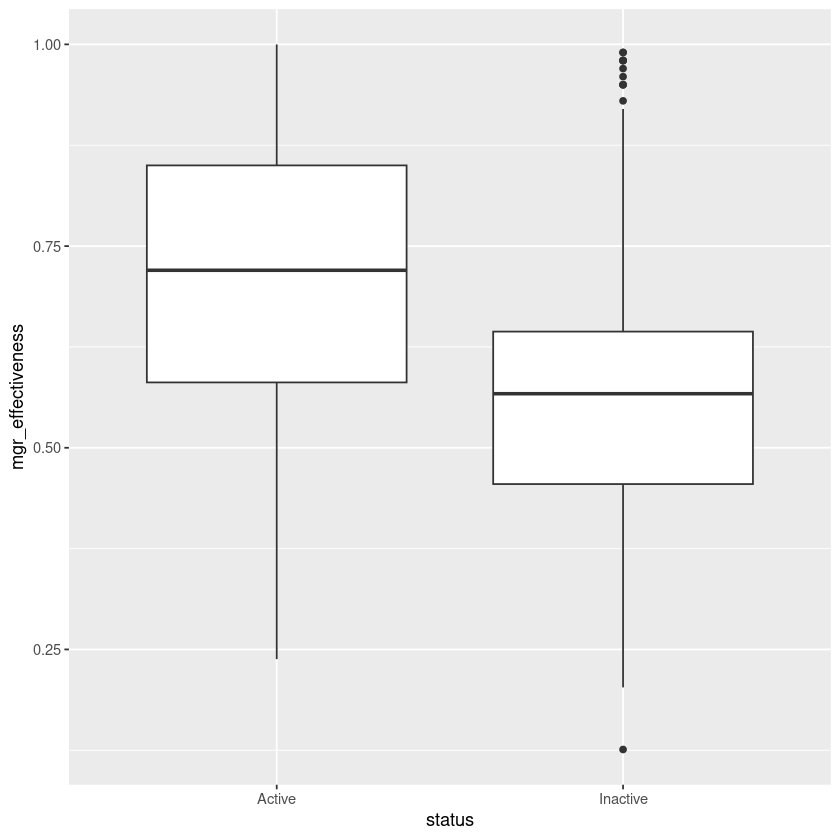

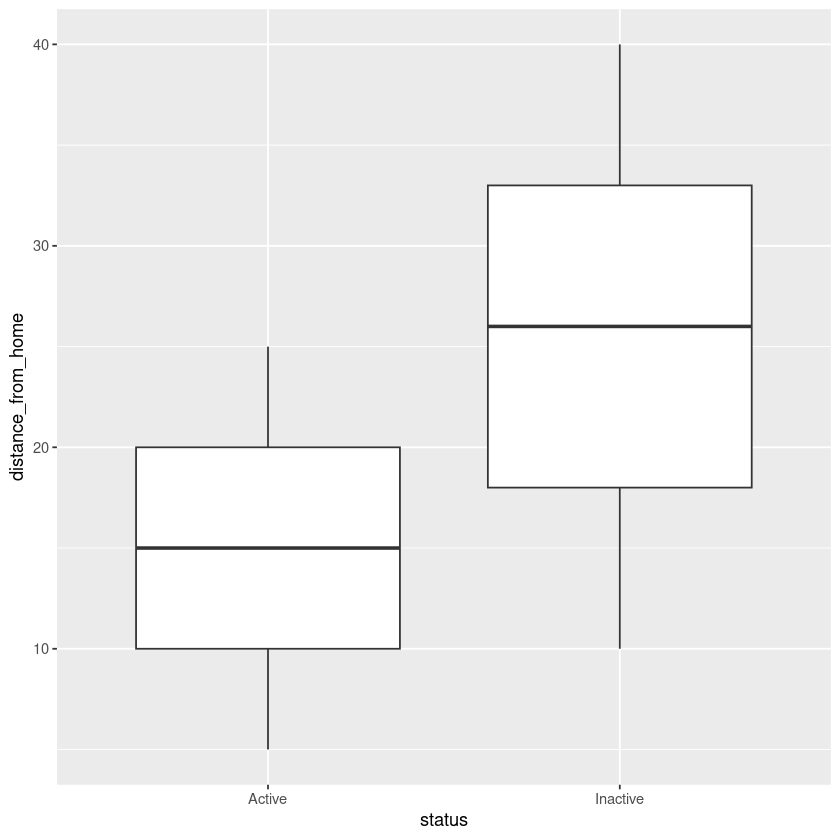

In [38]:
# Calculate turnover rate overall
org %>% 
  summarize(avg_turnover_rate = mean(turnover))

# Calculate turnover rate by level
org %>% 
  group_by(level) %>% 
  summarize(turnover_level = mean(turnover))

# Calculate turnover rate by performance rating
org %>% 
  group_by(rating) %>% 
  summarize(turnover_rating = mean(turnover))

# Plot turnover rate by manager rating
ggplot(org, aes(x = status, y = mgr_effectiveness)) +
  geom_boxplot()

# Plot turnover rate by commute distance
ggplot(org, aes(x = status, y = distance_from_home)) +
  geom_boxplot()

Lots of good insights here:
- The Analyst level has much higher turnover rates than that of Specialists.  
- Also, performance ratings seems highly correlated with ratings, with turnover being higher among employees with the worst performance ratings.  
- Further, employees that have left the company have a median commute that's much longer than the typical employee that's still with the company.

# **Feature Engineering**

## **Employee Tenure**

That was a good start, but we'll have to do some feature engineering in order to track some other potential drivers.  One such factor could be how long an employee worked/has worked for the organization.

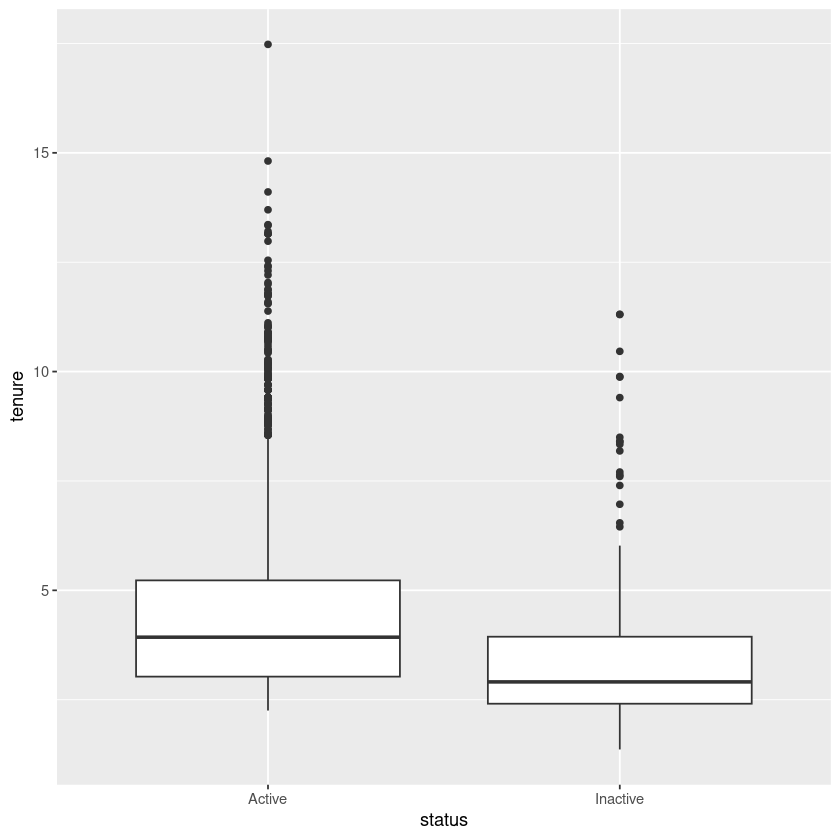

In [39]:
## Convert needed columns from character to date
org$date_of_joining <- dmy(org$date_of_joining)
org$last_working_date <- dmy(org$last_working_date)
org$cutoff_date <- dmy(org$cutoff_date)

## Code tenure for active and inactive employees based on last date of file or last working day, respectively
org <- org %>%
  mutate(tenure = ifelse(status == "Active", 
                         time_length(interval(date_of_joining, cutoff_date), 
                                     "years"), 
                         time_length(interval(date_of_joining, last_working_date), 
                                     "years")))

# Compare tenure of active and inactive employees
ggplot(org, aes(x = status, y = tenure)) + 
  geom_boxplot()

Looking at employee tenure by status, we can see that employees that have left the company tended to be with the company for a shorter span of time than those employees that are still with the company.  

## **Employee Pay **
Another potential factor is how much an employee is paid.  Though pay can vary among different levels, so we'll also want to create a median compensation by level to compare employees' salary to.  We'll create a pay_competitiveness field, which measures the ratio of an employee's compensation compared to the median compensation for that level.

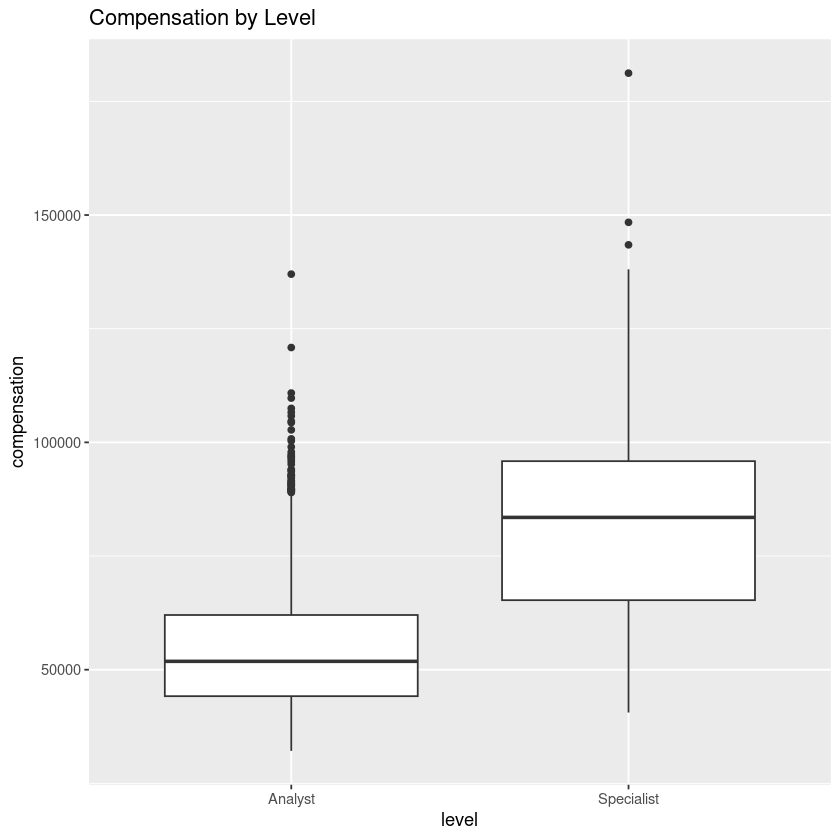

New names:
• `` -> `...1`


level,median_compensation
<chr>,<dbl>
Analyst,51840
Specialist,83496


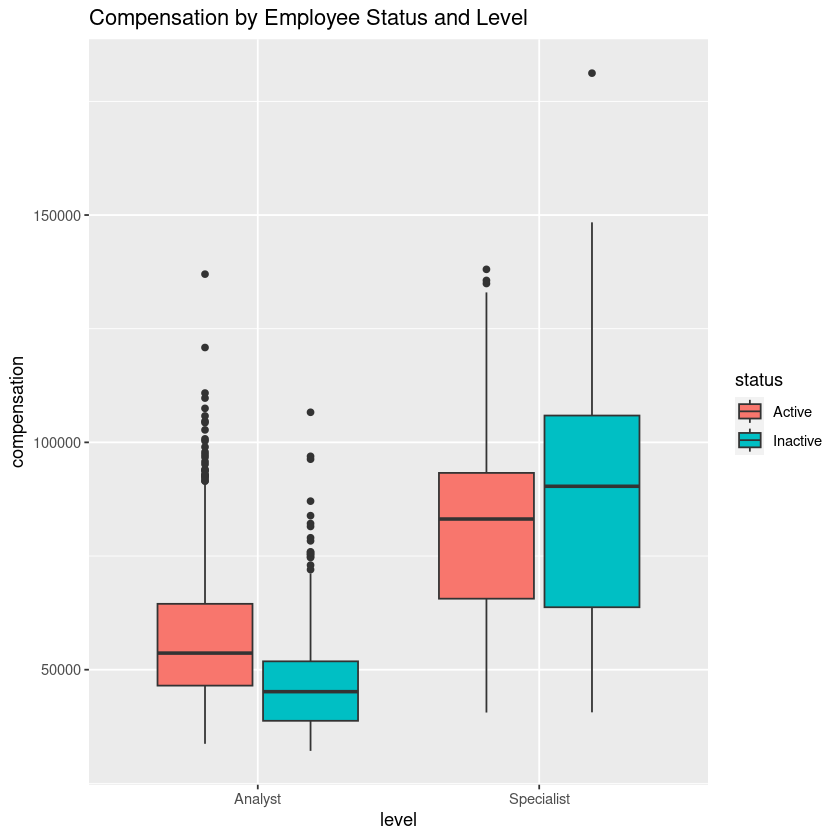

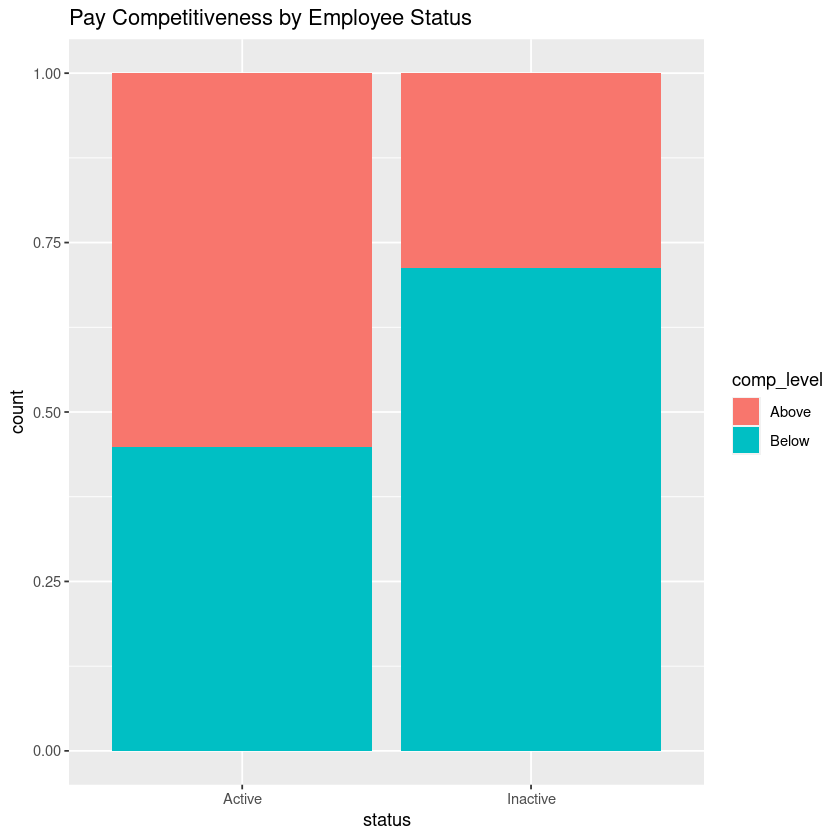

In [40]:
# Feature Engineering: Employee Pay Competitiveness

# Plot the distribution of compensation across levels
ggplot(org, 
       aes(x = level, y = compensation)) +
	ggtitle('Compensation by Level') +
  geom_boxplot()

# Compare compensation of Active and Inactive employees across levels
ggplot(org, 
       aes(x = level, y = compensation, fill = status)) + 
ggtitle('Compensation by Employee Status and Level') +
  geom_boxplot()

# Add median_compensation and pay_competiveness
org <- org %>%  
  group_by(level) %>%   
  mutate(median_compensation = median(compensation), 
         pay_competitiveness = compensation / median_compensation)

# Look at the median compensation for each level           
org  %>% 
  distinct(level, median_compensation)

# Add competitiveness level
org <- org %>%  
  mutate(comp_level = if_else(pay_competitiveness > 1, 'Above','Below'))

# Compare competitiveness level for Active & Inactive employees
ggplot(org, aes(x = status, fill = comp_level)) + 
 ggtitle('Pay Competitiveness by Employee Status') +
  geom_bar(position = "fill")

As Specialists' median pay is a lot more than Analysts, it's important to look at these 2 levels separately when comparing employee status.  

Looking at employee status by levels shows that the median income among departed Analysts is lower than that of active Analysts.  Interestingly, however, departed Specialists were actually more likely to have a higher median salary than that of active Specialists.

For that reason, we need to look at the competitiveness of pay for each employees, classifying any employee with pay higher than the median pay per level as "Above", and anyone with pay lower than the level's median pay as "Below". Interestingly, nearly 3/4 of departed employees had pay below the median salary for their level.

**Preparing the data for model building **

Before we can build a model, we're going to remove some columns that we don't want. We're also going to need to separate the data into a training set and test set to ensure we avoid biasing our model during the testing phase.  Let's spilit 70% of the data into a dataset that we can train the model on, and 30% on data that we can test on.

In [41]:
## Remove unwanted columns
org_final <- org %>% select(-c(emp_id,mgr_id,date_of_joining,
                        last_working_date,cutoff_date,mgr_age,emp_age,
                        median_compensation,department,status))

### Train-test split
set.seed(235)

# Store row numbers for training dataset: index_train
index_train <- createDataPartition(org_final$turnover, p = 0.70, list = FALSE)

# Create training dataset: train_set
train_set <- org_final[index_train, ]

# Create testing dataset: test_set
test_set <- org_final[-index_train, ]

**Building the logistic regression model**

In [42]:
# Build a multiple logistic regression model
multi_log <- glm(turnover ~ ., family = "binomial", 
                 data = org_final)

# Print summary
summary(multi_log)


Call:
glm(formula = turnover ~ ., family = "binomial", data = org_final)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.85462  -0.17432  -0.04784  -0.00024   3.09821  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -6.365e+00  3.360e+00  -1.894 0.058166 .  
locationNew York                8.961e-01  3.615e-01   2.479 0.013177 *  
locationOrlando                -9.944e-01  3.077e-01  -3.231 0.001232 ** 
levelSpecialist                 1.476e+01  5.111e+02   0.029 0.976954    
genderMale                      4.483e-01  2.644e-01   1.695 0.090020 .  
ratingAcceptable               -3.268e-01  3.003e-01  -1.088 0.276440    
ratingBelow Average            -2.275e+00  5.619e-01  -4.050 5.13e-05 ***
ratingExcellent                -9.418e-01  8.041e-01  -1.171 0.241518    
ratingUnacceptable             -3.753e+00  9.720e-01  -3.861 0.000113 ***
mgr_ratingAcceptable            1.069e-01  2.87

Lots of great insights and findings here initially, though there may be some multicollinearity among some of the categories, and thus we may need to remove some.  Let's use the car package to find out if there's any columns we'd like to remove.

In [43]:
vif(multi_log)

,GVIF,Df,GVIF^(1/(2*Df))
location,1.861841e+00,2,1.168115
level,2.441332e+06,1,1562.476377
gender,1.179324e+00,1,1.085967
rating,3.506442e+00,4,1.169791
mgr_rating,1.890156e+00,4,1.082835
mgr_reportees,1.211875e+00,1,1.100852
mgr_tenure,1.206903e+00,1,1.098591
compensation,3.771983e+01,1,6.141647
percent_hike,2.843890e+00,1,1.686384
hiring_score,1.109424e+00,1,1.053292


It looks like level is highly collinear with other columns in the dataset.  Let's try to run another model without that column.

In [44]:
# Build a multiple logistic regression model, removing level
multi_log <- glm(turnover ~ . -level, family = "binomial", 
                 data = org_final)

vif(multi_log)

,GVIF,Df,GVIF^(1/(2*Df))
location,1.857052,2,1.167363
gender,1.175432,1,1.084173
rating,3.411612,4,1.165789
mgr_rating,1.880747,4,1.082160
mgr_reportees,1.210331,1,1.100150
mgr_tenure,1.206695,1,1.098497
compensation,21.602525,1,4.647852
percent_hike,2.843375,1,1.686231
hiring_score,1.104730,1,1.051061
hiring_source,1.499224,6,1.034321


Alright, looks like compensation has popped up in terms of VIF.  Let's build a model that removes this, as well.

In [45]:
# Build a multiple logistic regression model, removing level and compensation
multi_log <- glm(turnover ~ . -level -compensation, family = "binomial", 
                 data = org_final)

vif(multi_log)

,GVIF,Df,GVIF^(1/(2*Df))
location,1.862138,2,1.168162
gender,1.175715,1,1.084304
rating,3.416839,4,1.166012
mgr_rating,1.814115,4,1.077291
mgr_reportees,1.213430,1,1.101558
mgr_tenure,1.196294,1,1.093752
percent_hike,2.885553,1,1.698691
hiring_score,1.114395,1,1.055649
hiring_source,1.463337,6,1.032235
no_previous_companies_worked,1.078428,1,1.038474


Alright, looks like we've stomped out the multicollinearity issues in our data!  Let's run the model again to see the results.

In [46]:
summary(multi_log)


Call:
glm(formula = turnover ~ . - level - compensation, family = "binomial", 
    data = org_final)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.72195  -0.18716  -0.05439  -0.00823   3.11149  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -7.90703    3.22307  -2.453 0.014157 *  
locationNew York                1.03466    0.35684   2.899 0.003738 ** 
locationOrlando                -0.86931    0.30290  -2.870 0.004105 ** 
genderMale                      0.45679    0.25844   1.767 0.077147 .  
ratingAcceptable               -0.33916    0.29180  -1.162 0.245118    
ratingBelow Average            -2.33489    0.54803  -4.260 2.04e-05 ***
ratingExcellent                -0.87029    0.80443  -1.082 0.279311    
ratingUnacceptable             -3.87028    0.96164  -4.025 5.71e-05 ***
mgr_ratingAcceptable            0.11167    0.28015   0.399 0.690177    
mgr_ratingBelow Average        -0.81813

There's a lot of factors that are statistically significant here.  Here are some of the highlights
- Percent_hike, the last raise in pay percent.  Employees with lower percentages were more likely to turnover.
- Employees with "Unacceptable" and "Below Average" ratings were more likely to turnover.
- Longer distances from home resulted in a higher likelihood of turnover.
- No_leaves_taken, representing total number of times PTO was taken.  The higher number of leaves taken, the higher the likelihood of turnover.
- Having more dependents increased the likelihood of turnover.
- Employees with managers that had lower effectiveness ratings were much more likely to turnover.

Using an assumption that anyone with a turnover probability > 50%, let's make some predictions and evaluate the model!

In [52]:
# Generate predicted probability of turnover for employees in the testing dataset
prediction_test <- predict(multi_log, newdata = test_set, 
                           type = "response")

# # Classify predictions using a cut-off of 0.5 - Anyone with a turnover probably greater than 
prediction_categories <- if_else(prediction_test > 0.5, 1, 0)

# Construct a confusion matrix
conf_matrix <- table(prediction_categories, test_set$turnover)

# Call confusionMatrix
confusionMatrix(conf_matrix)

Confusion Matrix and Statistics

                     
prediction_categories   0   1
                    0 469  17
                    1   8  92
                                          
               Accuracy : 0.9573          
                 95% CI : (0.9377, 0.9722)
    No Information Rate : 0.814           
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8545          
                                          
 Mcnemar's Test P-Value : 0.1096          
                                          
            Sensitivity : 0.9832          
            Specificity : 0.8440          
         Pos Pred Value : 0.9650          
         Neg Pred Value : 0.9200          
             Prevalence : 0.8140          
         Detection Rate : 0.8003          
   Detection Prevalence : 0.8294          
      Balanced Accuracy : 0.9136          
                                          
       'Positive' Class : 0           

The model is 95% accurate!  We were able to correctly predict turnover among 84.4% of the employees that left the company, and predict no turnover among 98% of the employees with no turnover.

**Getting practical **
It's great that we were able to test the model successfully.  However, you can only take action on employees that are still with the company.  Let's go back to the original dataset and predict probability of turnover among the active employees.  It may also be helpful to classify employees into different risk buckets.

In [57]:
# Calculate probability of turnover
emp_risk <- org %>%
  filter(status == "Active") %>%
  tidypredict_to_column(multi_log)

# Create turnover risk buckets
emp_risk_bucket <- emp_risk %>% 
  mutate(risk_bucket = cut(fit, breaks = c(0, 0.5, 0.6, 0.8, 1), 
                           labels = c("no-risk", "low-risk", 
                                      "medium-risk", "high-risk")))

# Count employees in each risk bucket
emp_risk_bucket %>% 
  count(risk_bucket)

New names:
• `` -> `...1`


level,risk_bucket,n
<chr>,<fct>,<int>
Analyst,no-risk,1229
Analyst,low-risk,11
Analyst,medium-risk,12
Analyst,high-risk,7
Specialist,no-risk,293
Specialist,medium-risk,3
Specialist,high-risk,2
